# 음성 합성(Speech Synthesis)

* https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/SpeechSynthesis/Tacotron2

## Tacotron 2

* 텍스트에서 멜 스펙트로그램 생성

* https://pytorch.org/hub/nvidia_deeplearningexamples_tacotron2/

<img src="https://pytorch.org/assets/images/tacotron2_diagram.png" alt="alt" width="50%"/>

## WaveGlow

* 멜 스펙트로그램에서 음성 생성

* https://pytorch.org/hub/nvidia_deeplearningexamples_waveglow/

<img src="https://pytorch.org/assets/images/waveglow_diagram.png" alt="alt" width="50%"/>

In [1]:
!pip install numpy scipy librosa unidecode inflect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 5.2 MB/s 


* LJ Speech dataset에서 사전 학습된 Tacotron2와 WaveGlow 모델 로드

In [17]:
import torch

tacotron2 = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_tacotron2')  
processing = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_tts_utils')
waveglow = torch.hub.load('nvidia/DeepLearningExamples:torchhub','nvidia_waveglow')

Using cache found in /root/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub
Using cache found in /root/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub
Using cache found in /root/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub


In [18]:
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (lin

In [19]:
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0): WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (1): Conv1d(51

## Text To Speech(TTS)

In [20]:
import numpy as np


import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

def plot_data(data, figsize=(16,4)):
  fig, axes = plt.subplots(1, len(data), figsize=figsize)
  for i in range(len(data)):
    axes[i].imshow(data[i], aspect='auto', origin='bottom', interpolation='none', cmap='viridis')

def TTS(text):

    sampling_rate = 22050

    #####   text_to_sequence 가 tacotron2 에 없고 Process  클라스 안에 prepare_input_sequence 에 있습니다. ######

    #sequence, _ = np.array(tacotron2.text_to_sequence(text, ['english_cleaners']))[None,:]      
    #sequence = torch.from_numpy(sequence).to(device='cuda', dtype=torch.int64)
    sequence, input_lengths = processing.prepare_input_sequence([text])             #위 두줄을 이 코드로 대체하고 text 는 리스트로 바꾸시고
    
    with torch.no_grad():
        #mel_outputs, mel_outputs_postnet, _, alignments = tacotron2.infer(sequence)
        mel_outputs_postnet, mel_lengths, alignments= tacotron2.infer(sequence, input_lengths)  # 이걸로 바꾸고 input_lengths 를 추가하고 
        audio = waveglow.infer(mel_outputs_postnet)

    #mel_output =  mel_outputs.data.cpu().numpy()[0]      #이건 없애주세요,  mel_output 은 만들어 지지 않습니다.
    mel_output_postnet = mel_outputs_postnet.data.cpu().numpy()[0]
    alignment = alignments.data.cpu().numpy()[0].T
    audio_np = audio[0].data.cpu().numpy()

    return mel_output_postnet, alignment, audio_np, sampling_rate      # return 할 때도  mel_output 은 빼 주시고
    # return mel_output, mel_output_postnet, alignment, audio_np, sampling_rate

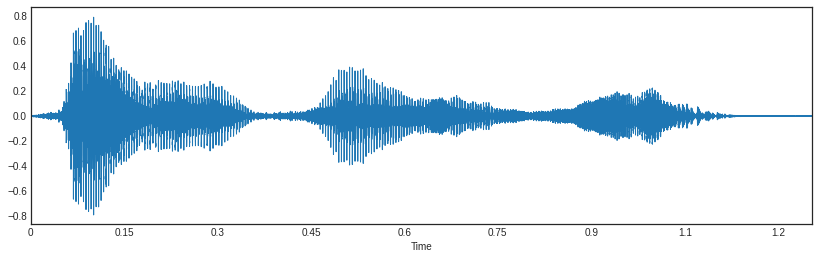

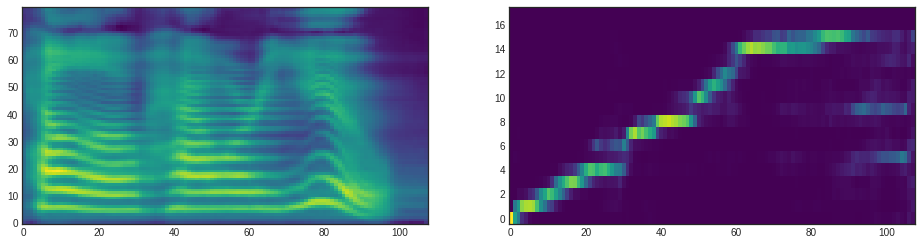

In [21]:
import librosa.display
from IPython.display import Audio

text = "Hello, how are you"
#mel_output, mel_output_postnet, alignment, audio_np, sampling_rate = TTS(text)
mel_output_postnet, alignment, audio_np, sampling_rate = TTS(text)

fig = plt.figure(figsize=(14,4))
librosa.display.waveplot(audio_np, sr=sampling_rate)
plot_data((mel_output_postnet, alignment))
#plot_data((mel_output, mel_output_postnet, alignment))
Audio(audio_np, rate=sampling_rate)


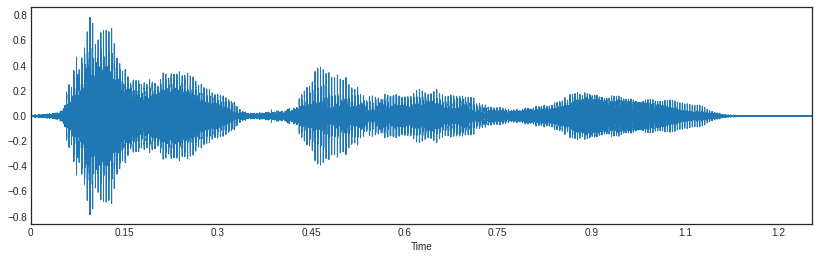

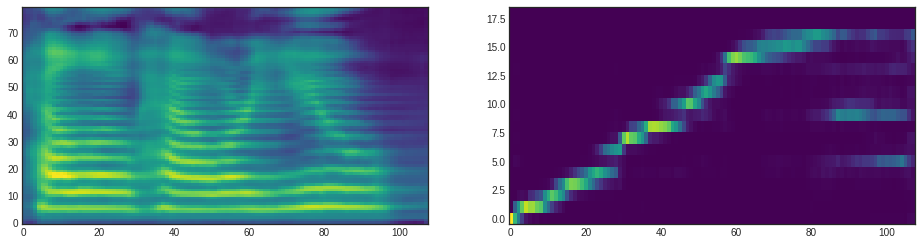

In [30]:
import librosa.display
from IPython.display import Audio

text = 'Hello, how are you?'
mel_output_postnet, alignment, audio_np, sampling_rate = TTS(text)

fig = plt.figure(figsize=(14,4))
librosa.display.waveplot(audio_np, sr=sampling_rate)
plot_data((mel_output_postnet, alignment))
Audio(audio_np, rate=sampling_rate)

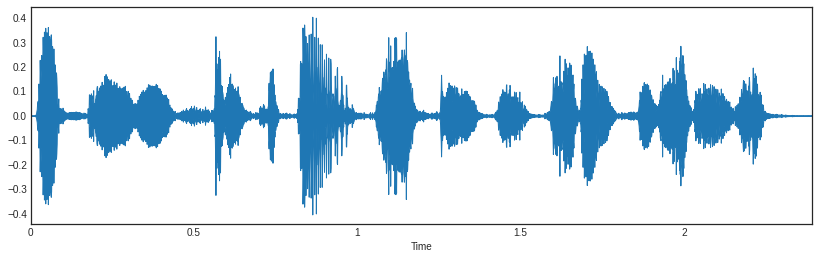

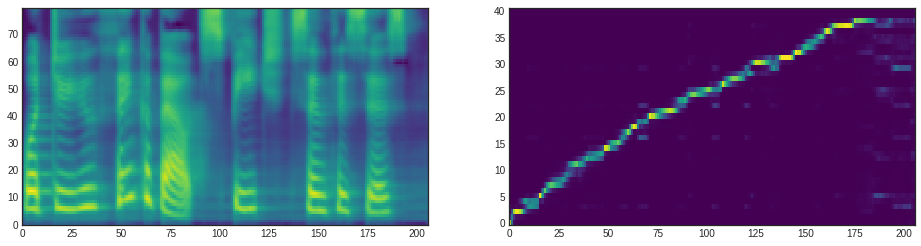

In [31]:
import librosa.display
from IPython.display import Audio

text = 'What do you think about speech synthesis?'
mel_output_postnet, alignment, audio_np, sampling_rate = TTS(text)

fig = plt.figure(figsize=(14,4))
librosa.display.waveplot(audio_np, sr=sampling_rate)
plot_data((mel_output_postnet, alignment))
Audio(audio_np, rate=sampling_rate)